Import Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving BBC News Train.csv to BBC News Train.csv


In [47]:
from google.colab import files
uploaded = files.upload()

Saving art1.txt to art1.txt
Saving art2.txt to art2.txt
Saving art3.txt to art3.txt
Saving art4.txt to art4.txt
Saving articles urls.txt to articles urls.txt


Import Library

In [31]:
import pandas as pd
import re 

import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost 
from sklearn.metrics  import classification_report
from sklearn import metrics
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [32]:
df1 = pd.read_csv('BBC News Train.csv')
df1.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [33]:
category = list(df1['Category'].unique())
category

['business', 'tech', 'politics', 'sport', 'entertainment']

Visualisasi Data Berdasarkan Kategori

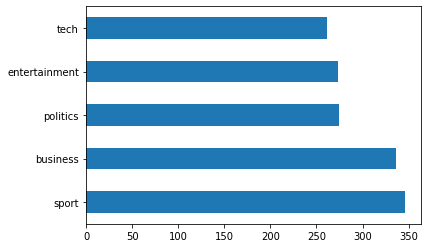

In [34]:
df1['Category'].value_counts().plot(kind='barh')
plt.show()

In [35]:
df1.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [36]:

# Text preprocessing
def preprocess(text):
    
    """
    Function: split text into words and return the root form of the words
    Args:
      text(str): the article
    Return:
      lem(list of str): a list of the root form of the article words
    """
        
    # Normalize text
    text = re.sub(r"[^a-zA-Z]", " ", str(text).lower())
    
    # Tokenize text
    token = word_tokenize(text)
    
    # Remove stop words
    stop = stopwords.words("english")
    words = [t for t in token if t not in stop]
    
    # Lemmatization
    lem = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return lem

In [37]:
df1["Preprocessed_Text"] = df1['Text'].apply(lambda x: preprocess(x))
df1.head(10)

,ArticleId,Text,Category,Preprocessed_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, bos, launch, defence, lawyer, d..."
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, boss, payout, eighteen, former, enron,..."
5,1582,howard truanted to play snooker conservative...,politics,"[howard, truanted, play, snooker, conservative..."
6,651,wales silent on grand slam talk rhys williams ...,sport,"[wale, silent, grand, slam, talk, rhys, willia..."
7,1797,french honour for director parker british film...,entertainment,"[french, honour, director, parker, british, fi..."
8,2034,car giant hit by mercedes slump a slump in pro...,business,"[car, giant, hit, mercedes, slump, slump, prof..."
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,"[fockers, fuel, festive, film, chart, comedy, ..."


In [38]:

print("Most common words in each category")
for c in category:
    print(c, " News")
    print(find_common_words(df1, c))
    print()

Most common words in each category
business  News
[('said', 1100), ('year', 618), ('bn', 535), ('u', 523), ('mr', 394), ('company', 393), ('firm', 374), ('market', 346), ('would', 309), ('also', 279)]

tech  News
[('said', 1064), ('people', 647), ('mobile', 437), ('phone', 396), ('game', 396), ('technology', 380), ('service', 371), ('one', 367), ('year', 364), ('mr', 350)]

politics  News
[('said', 1445), ('mr', 1100), ('would', 712), ('labour', 494), ('election', 479), ('government', 471), ('party', 464), ('blair', 396), ('minister', 373), ('people', 372)]

sport  News
[('said', 636), ('game', 487), ('year', 448), ('first', 350), ('win', 337), ('time', 336), ('england', 329), ('player', 311), ('two', 290), ('back', 279)]

entertainment  News
[('film', 721), ('said', 594), ('year', 450), ('best', 430), ('award', 336), ('u', 290), ('also', 277), ('one', 274), ('show', 273), ('star', 259)]



In [39]:
df1['Preprocessed_Text2'] = df1['Preprocessed_Text'].apply(' '.join)
df1.head()

,ArticleId,Text,Category,Preprocessed_Text,Preprocessed_Text2
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, bos, launch, defence, lawyer, d...",worldcom ex bos launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize...",bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, boss, payout, eighteen, former, enron,...",enron boss payout eighteen former enron direct...


In [40]:
X = df1['Preprocessed_Text2']
y = df1['Category']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
tf_vec = TfidfVectorizer()
train_features = tf_vec.fit(X_train)
train_features = tf_vec.transform(X_train)
test_features = tf_vec.transform(X_test)

In [43]:
# Train and evaluate model
def fit_eval_model(model, train_features, y_train, test_features, y_test):
    
    """
    Function: train and evaluate a machine learning classifier.
    Args:
      model: machine learning classifier
      train_features: train data extracted features
      y_train: train data lables
      test_features: train data extracted features
      y_test: train data lables
    Return:
      results(dictionary): a dictionary of the model training time and classification report
    """
    results ={}
    
    # Start time
    start = time.time()
    # Train the model
    model.fit(train_features, y_train)
    # End time
    end = time.time()
    # Calculate the training time
    results['train_time'] = end - start
    
    # Test the model
    train_predicted = model.predict(train_features)
    test_predicted = model.predict(test_features)
    
     # Classification report
    results['classification_report'] = classification_report(y_test, test_predicted)
        
    return results

In [44]:
# Initialize the models
sv = svm.SVC()
ab = AdaBoostClassifier(random_state = 1)
gb = GradientBoostingClassifier(random_state = 1)
xgb = xgboost.XGBClassifier(random_state = 1)
tree = DecisionTreeClassifier()
nb = MultinomialNB()


# Fit and evaluate models
results = {}
for cls in [sv, ab, gb, xgb, tree, nb]:
    cls_name = cls.__class__.__name__
    results[cls_name] = {}
    results[cls_name] = fit_eval_model(cls, train_features, y_train, test_features, y_test)

In [45]:
# Print classifiers results
for res in results:
    print (res)
    print()
    for i in results[res]:
        print (i, ':')
        print(results[res][i])
        print()
    print ('-----')
    print()

SVC

train_time :
3.9393186569213867

classification_report :
               precision    recall  f1-score   support

     business       0.95      0.99      0.97        74
entertainment       0.98      0.98      0.98        54
     politics       0.98      0.91      0.94        56
        sport       1.00      1.00      1.00        72
         tech       0.98      1.00      0.99        42

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298


-----

AdaBoostClassifier

train_time :
1.4826781749725342

classification_report :
               precision    recall  f1-score   support

     business       0.67      0.47      0.56        74
entertainment       0.67      0.41      0.51        54
     politics       0.77      0.64      0.70        56
        sport       0.53      0.99      0.69        72
         tech       0.84      0.64      0.73        42

     accuracy          

In [46]:
# Classify an article
def classify_article(path):
    
    """
    Function: classify an article.
    Args:
      path: the path of the article 
    Return:
      category (str): the category of the article
    """
    # Read file
    file = open(path, 'r')
    artcl = file.read()

    # Text preprocessing
    artcl = preprocess(artcl)
    artcl = ' '.join(artcl)

    # Use TF_IDF
    test = tf_vec.transform([artcl])

    # Use MultinomialNB model to classify the article
    predict = nb.predict(test)
    category = predict[0]

    # Close file
    file.close()

    return category

In [49]:
print(classify_article('art1.txt'))

sport


In [50]:
print(classify_article('art2.txt'))

business
